In [72]:
import networkx as nx
import pandas as pd
import math
import matplotlib.pyplot as plt

## Dataset to use

In [113]:
coefs_path = '../results/lasso_test_normalized.csv'
coefs = pd.read_csv(coefs_path)

# Determine coef cut off based on having an average of 3 coefs

In [114]:
top_coefs_dict = {'course': [], 'coef_1': [], 'coef_2': [], 'coef_3': []}
for course in coefs['course']:
    top_coefs = coefs.loc[(coefs['course'] == course)].iloc[0][1:].sort_values(ascending=False)[:3]
    top_coefs_dict['course'].append(course)
    top_coefs_dict['coef_1'].append(top_coefs[0])
    top_coefs_dict['coef_2'].append(top_coefs[1])
    top_coefs_dict['coef_3'].append(top_coefs[2])

In [115]:
CUTOFF = pd.DataFrame.from_dict(top_coefs_dict).dropna().mean(axis = 0).mean()

In [116]:
CUTOFF

0.24382225407476962

In [117]:
sorted_predictors = coefs.loc[(coefs['course'] == "CS229")].iloc[0][1:].sort_values(ascending=False)
sorted_predictors

CS107          0.163711
CS221          0.114223
PHYSICS63      0.104185
CS107E        0.0962494
MATH52        0.0839993
                ...    
STATS344            NaN
STATS360            NaN
PHIL180A            NaN
IPS203              NaN
GEOPHYS281          NaN
Name: 84, Length: 1007, dtype: object

# Graphing

In [142]:
lowest_depth = {}

In [143]:
def construct_directed_graph(current_course, coefs, breadth, depth, G):
    if (depth == 0):
        return
    depth -= 1
    if (len(coefs.loc[(coefs['course'] == current_course)]) < 1):
        return
    sorted_predictors = coefs.loc[(coefs['course'] == current_course)].iloc[0][1:].sort_values(ascending=False)
    top_predictors = sorted_predictors[:breadth]
    for index, value in top_predictors.items():
        if (not math.isnan(value) and value > 0 and not G.has_edge(index, current_course)):
            
            G.add_node(index, layer=lowest_depth[index])
            G.add_edge(index, current_course, weight=(value**2)*50)
            construct_directed_graph(index, coefs, breadth, depth, G)
        elif G.has_edge(index, current_course):
            pass
#             print(index, current_course)

In [144]:
def construct_breadth_first_ordered_graph(current_course, coefs, breadth, depth, G):
    if (depth == 0):
        return
    depth -= 1
    if (len(coefs.loc[(coefs['course'] == current_course)]) < 1):
        return
    sorted_predictors = coefs.loc[(coefs['course'] == current_course)].iloc[0][1:].sort_values(ascending=False)
    top_predictors = sorted_predictors[:breadth]
    for index, value in top_predictors.items():
        if (not math.isnan(value) and value > 0 and not G.has_edge(index, current_course)):
            G.add_node(index, layer=lowest_depth[index])
            if lowest_depth[current_course] > lowest_depth[index]: 
                G.add_edge(index, current_course, weight=value)
            construct_breadth_first_ordered_graph(index, coefs, breadth, depth, G)
        elif G.has_edge(index, current_course):
            pass
#             print(index, current_course)

In [145]:
def fill_layers(current_course, coefs, breadth, depth, G):
    if (depth == 0):
        return
    depth -= 1
    if (len(coefs.loc[(coefs['course'] == current_course)]) < 1):
        return
    sorted_predictors = coefs.loc[(coefs['course'] == current_course)].iloc[0][1:].sort_values(ascending=False)
    top_predictors = sorted_predictors[:breadth]
    for index, value in top_predictors.items():
        if (not math.isnan(value) and value > 0):
            if index not in lowest_depth or depth < lowest_depth[index]:
                lowest_depth[index] = depth
            G.add_node(index, layer=depth)
            G.add_edge(index, current_course)
            fill_layers(index, coefs, breadth, depth, G)
        elif G.has_edge(index, current_course):
            pass
#             print(index, current_course)

In [146]:
#Computing of the graph
target_course = 'CS229'
depth = 10
breadth = 3

G = nx.DiGraph()
G.add_node(target_course, layer=depth)
lowest_depth[target_course] = depth
fill_layers(target_course, coefs, breadth, depth, G)
G = nx.DiGraph()
G.add_node(target_course, layer=depth)
construct_directed_graph(target_course, coefs, breadth, depth, G)

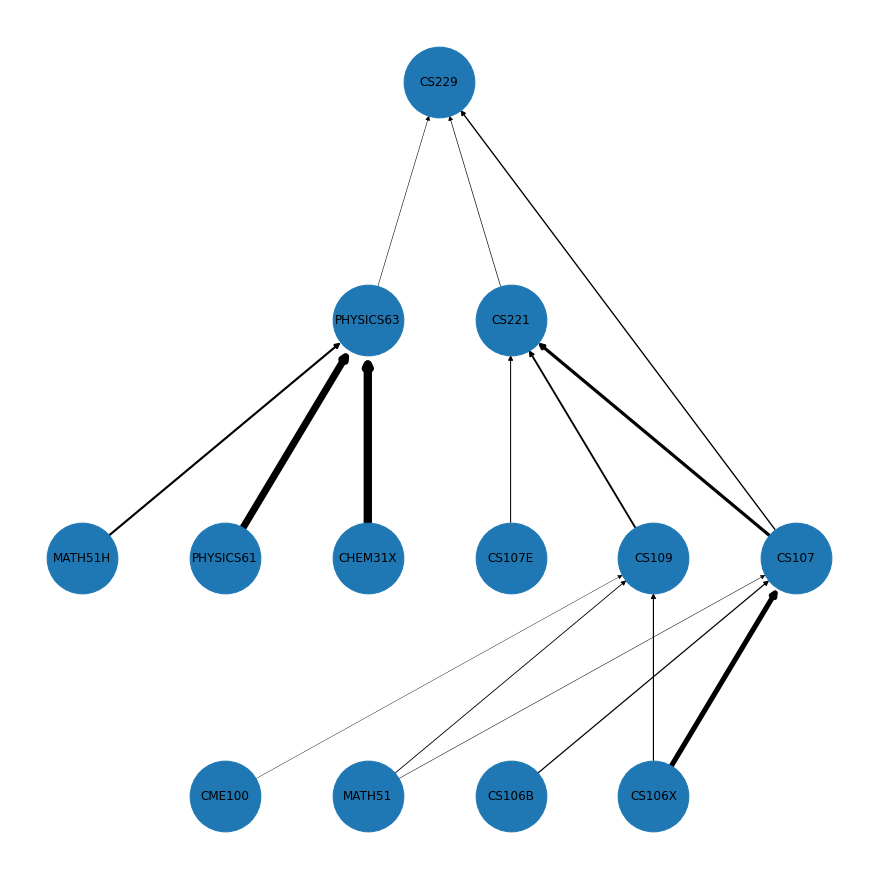

In [147]:
#Drawing of the graph
weights = [G[u][v]['weight'] for u,v in G.edges]
plt.figure(figsize=(12,12)) 
pos=nx.multipartite_layout(G, subset_key='layer', align='horizontal')
nx.draw(G, pos=pos, node_size = 5000, width=weights)
labels=nx.draw_networkx_labels(G, pos=pos)

In [19]:
nx.find_cycle(G)
G.get_edge_data('CS107', 'CS229')

NetworkXNoCycle: No cycle found.

In [20]:
len(list(nx.simple_cycles(G)))

0

In [21]:
lowest_depth

{'CS229': 4, 'OSPSANTG130X': 3, 'CME305': 3, 'BIOMEDIN260': 3}